<a href="https://colab.research.google.com/github/cultureincities/sport/blob/master/code/Lausanne2020_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%time 
!apt update
!apt upgrade
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,814

In [0]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Vaud District Boundaries

In [0]:
# Read in the Vaud boundaries data which lives in our GitHub repo
gdf_vaud = gpd.read_file('http://cultureincities.com/sport/data/geometry_district.geojson')
gdf_vaud.head(5)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ..."
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ..."
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ..."
3,32,2.904487e+06,8368.067727,22,Coinsins,COINSINS,2228,5710,231,8,"POLYGON ((6.25078 46.41559, 6.24994 46.41530, ..."
4,33,1.018120e+07,18942.417911,22,Grandcour,GRANDCOUR,2222,5817,309,2,"POLYGON ((6.91080 46.88062, 6.91791 46.88414, ..."


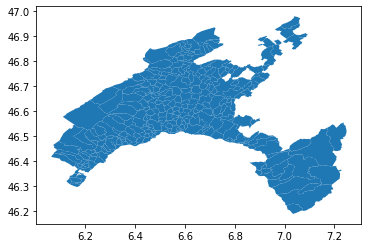

In [0]:
#view the boundaries
gdf_vaud.plot()

## Airbnb Data

In [0]:
# Read in the Airbnb data which lives in our GitHub repo
airbnb = pd.read_csv('http://cultureincities.com/sport/data/airbnb/airbnb_vaud_january_since2016.csv')
airbnb.drop(columns={'Unnamed: 0'}, inplace=True)
airbnb.head()

,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day
0,26809,60024638,2016-01-18,37911239,Jeremy,"Appartement très propre, calme et bien situé d...","Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,18
1,26809,60359278,2016-01-22,45132344,Luigina,I spent recently two days by Eric's home and i...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,22
2,26809,60899288,2016-01-29,51714467,Pascale,Éric est un hôte chaleureux et arrangeant.\r\n...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,29
3,26809,128022235,2017-01-22,18549056,Manoug,Excellent comme les fois précédentes.,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2017,1,22
4,233016,586681124,2020-01-02,307241152,Antonio,We enjoyed the place. Thank you!,Your little piece of Paradise!,1219574,Michael,Aigle,Ormont-Dessus,46.34960,7.16248,Entire home/apt,125,2020,1,2


In [0]:
# Transform the pandas df file into a geopandas df (Geometry from point polygon!)
airbnb_geo = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))

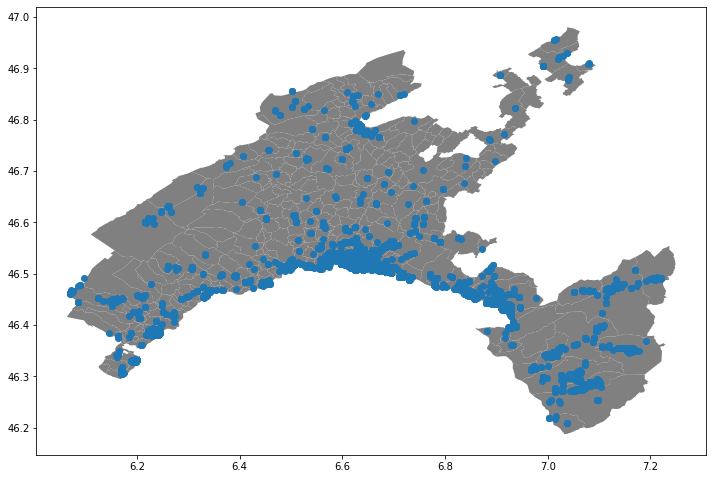

In [0]:
# Plot the Airbnb lisings on top of the Vaud Boundary data
fig, ax = plt.subplots(figsize=(12,10))
gdf_vaud.plot(color="Gray", ax= ax);
airbnb_geo.plot(ax=ax);

In [0]:
# Make sure that the Vaud and Airbnb geopandas dataframe a CRS of 4326
gdf_vaud.crs = 'EPSG:4326'
airbnb_geo.crs = 'EPSG:4326'

In [0]:
# Check to see if the CRS is the same
gdf_vaud.crs == airbnb_geo.crs

True

In [0]:
airbnb_geo.head(2)

,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day,geometry
0,26809,60024638,2016-01-18,37911239,Jeremy,"Appartement très propre, calme et bien situé d...","Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,18,POINT (6.66425 46.52228)
1,26809,60359278,2016-01-22,45132344,Luigina,I spent recently two days by Eric's home and i...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,22,POINT (6.66425 46.52228)


In [0]:
gdf_vaud.head(2)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ..."
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ..."


### Spatial join

In [0]:
# Do a spatial join of the Vaud Boundary data and the Airbnb listings
sjoined_listings = gpd.sjoin(gdf_vaud, airbnb_geo, op="contains")
sjoined_listings.head()

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,index_right,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ...",185,2436952,129081833,2017-01-29,14152607,Filipe,"Maurice is an amazing Host, very helpful Perso...",CONFORT - VIEW - GOOD PRICE 6 ROOMS - 2/7 GUESTS,12455032,Maurice,Morges,Yens,46.51809,6.41755,Entire home/apt,99,2017,1,29
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",510,5108203,367152179,2019-01-04,55083813,Pierre,LA PETITE MAISON est jolie et magnifiquement s...,La Petite Maison,26302035,Huguette,Morges,Echichens,46.52850,6.50179,Entire home/apt,113,2019,1,4
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1791,15502391,125730978,2017-01-07,79421272,Francois,The host canceled this reservation 15 days bef...,Appartement charmant sur Léman,69219491,Alain,Morges,Echichens,46.52654,6.49818,Entire home/apt,95,2017,1,7
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1730,15177381,599863257,2020-01-31,260249457,Nicolas,"Studio très bien équipé, très bien situé, calm...",Studio spacieux et confortable,26302035,Huguette,Morges,Echichens,46.52682,6.50258,Entire home/apt,65,2020,1,31
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1729,15177381,128735679,2017-01-27,98968559,Julien,"Très bon accueil, joli lieu et très belle vue ...",Studio spacieux et confortable,26302035,Huguette,Morges,Echichens,46.52682,6.50258,Entire home/apt,65,2017,1,27


In [0]:
# Group by Neighbbourhood and count the number of listings by each year
x = sjoined_listings.groupby(['neighbourhood', 'review_year'], group_keys=False).\
    apply(lambda x: pd.Series(x.neighbourhood.count())).unstack()

# Because the dataframe has multiple indecies, choose the index at level 1, which are the years
x.columns = x.columns.get_level_values(1)

# Remove rows where null rows
# x = x[x.isnull().sum(axis=1) < 3]
x.dropna(inplace=True)
x.sort_values(by=2020, ascending=False, inplace=True)

x.head()

review_year,2016,2017,2018,2019,2020
neighbourhood,,,,,
Lausanne,101.0,194.0,399.0,366.0,633.0
Montreux,19.0,36.0,118.0,116.0,170.0
Ollon,24.0,40.0,68.0,82.0,131.0
Leysin,12.0,21.0,31.0,64.0,82.0
Gryon,23.0,32.0,46.0,39.0,62.0


In [0]:
# # https://stackoverflow.com/questions/47649291/using-pandas-and-scipy-regression-line-slope-to-identify-growth

# axisvalues= np.arange(1,len(x.columns)+1)

# def calc_slope(row):
#     #mask NaNs out
#     mask = row.notnull()
#     a = scipy.stats.linregress(row[mask.values], y=axisvalues[mask])
#     return pd.Series(a._asdict())

# x = x.join(x.apply(calc_slope,axis=1))

In [0]:
# Calculate the demand change from 2019 to 2020
x['demand_change_19_20'] = 100*(x[2020]/x[2019])

In [0]:
x.head()

review_year,2016,2017,2018,2019,2020,demand_change_19_20
neighbourhood,,,,,,
Lausanne,101.0,194.0,399.0,366.0,633.0,172.950820
Montreux,19.0,36.0,118.0,116.0,170.0,146.551724
Ollon,24.0,40.0,68.0,82.0,131.0,159.756098
Leysin,12.0,21.0,31.0,64.0,82.0,128.125000
Gryon,23.0,32.0,46.0,39.0,62.0,158.974359


In [0]:
# Calculate the demand change from 2019 to 2020

x = x[x[2020] >= 10]

print(x.shape)

(28, 6)


In [0]:
x.sort_values(by='demand_change_19_20', ascending=False)

review_year,2016,2017,2018,2019,2020,demand_change_19_20
neighbourhood,,,,,,
Renens (Vaud),1.0,4.0,7.0,6.0,47.0,783.333333
Bex,3.0,1.0,6.0,4.0,26.0,650.000000
Yverdon-les-Bains,2.0,1.0,10.0,6.0,26.0,433.333333
Chardonne,1.0,9.0,4.0,3.0,10.0,333.333333
Epalinges,2.0,7.0,5.0,10.0,30.0,300.000000
Pully,6.0,7.0,7.0,16.0,48.0,300.000000
Saint-Cergue,2.0,6.0,22.0,13.0,36.0,276.923077
Vevey,4.0,14.0,27.0,18.0,49.0,272.222222
Lutry,1.0,14.0,10.0,8.0,20.0,250.000000


In [0]:
x.reset_index(inplace=True)

In [0]:
x.columns = ['neighbourhood', 'review_count_2016', 'review_count_2017', 'review_count_2018', 'review_count_2019', 'review_count_2020', 'demand_change_19_20']
x = x.loc[:, ['neighbourhood', 'review_count_2019', 'review_count_2020', 'demand_change_19_20']]
x.head()

,neighbourhood,review_count_2019,review_count_2020,demand_change_19_20
0,Lausanne,366.0,633.0,172.950820
1,Montreux,116.0,170.0,146.551724
2,Ollon,82.0,131.0,159.756098
3,Leysin,64.0,82.0,128.125000
4,Gryon,39.0,62.0,158.974359


In [0]:
# Neighbourhood replace
x['neighbourhood'] = x['neighbourhood'].replace("Renens (Vaud)", "Renens (VD)")
x['neighbourhood'] = x['neighbourhood'].replace("Villeneuve (Vaud)", "Villeneuve (VD)")

In [0]:
# Change column in boundary shapefile
gdf_vaud.columns = ['OBJECTID', 'SHAPE_AREA', 'SHAPE_LEN', 'NO_CANTON', 'neighbourhood',
       'NOM_MAJ', 'NO_DIS_FED', 'NO_COM_FED', 'NO_COM_CAN', 'NO_DIS_CAN',
       'geometry']

In [0]:
airbnb_merged = gdf_vaud.merge(x, on='neighbourhood', how='outer')

airbnb_merged.review_count_2019.fillna(0, inplace=True)
airbnb_merged.review_count_2020.fillna(0, inplace=True)
airbnb_merged.demand_change_19_20.fillna(0, inplace=True)

airbnb_merged.head()

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,review_count_2019,review_count_2020,demand_change_19_20
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ...",0.0,0.0,0.0
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ...",0.0,0.0,0.0
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",0.0,0.0,0.0
3,32,2.904487e+06,8368.067727,22,Coinsins,COINSINS,2228,5710,231,8,"POLYGON ((6.25078 46.41559, 6.24994 46.41530, ...",0.0,0.0,0.0
4,33,1.018120e+07,18942.417911,22,Grandcour,GRANDCOUR,2222,5817,309,2,"POLYGON ((6.91080 46.88062, 6.91791 46.88414, ...",0.0,0.0,0.0


In [0]:
# Check if there are any null
airbnb_merged[pd.isnull(airbnb_merged).any(axis=1)]

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,review_count_2019,review_count_2020,demand_change_19_20


In [0]:
airbnb_merged.sort_values(by='demand_change_19_20', ascending=False)[:5]

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,review_count_2019,review_count_2020,demand_change_19_20
251,262,2.956124e+06,8728.287307,22,Renens (VD),RENENS (VD),2229,5591,137,9,"POLYGON ((6.60211 46.52463, 6.60060 46.52364, ...",6.0,47.0,783.333333
127,114,9.658051e+07,55455.388370,22,Bex,BEX,2221,5402,2,1,"POLYGON ((7.00814 46.22005, 7.00723 46.22148, ...",4.0,26.0,650.000000
267,278,1.350194e+07,24950.294243,22,Yverdon-les-Bains,YVERDON-LES-BAINS,2224,5938,387,4,"POLYGON ((6.65095 46.75674, 6.65059 46.75630, ...",6.0,26.0,433.333333
117,104,1.030185e+07,16640.034577,22,Chardonne,CHARDONNE,2230,5882,340,10,"POLYGON ((6.79882 46.47213, 6.79900 46.47467, ...",3.0,10.0,333.333333
297,308,5.842606e+06,16465.955309,22,Pully,PULLY,2226,5590,136,6,"POLYGON ((6.66821 46.50449, 6.66761 46.50398, ...",16.0,48.0,300.000000


In [0]:
airbnb_merged.shape[0] == airbnb.shape[0]

False

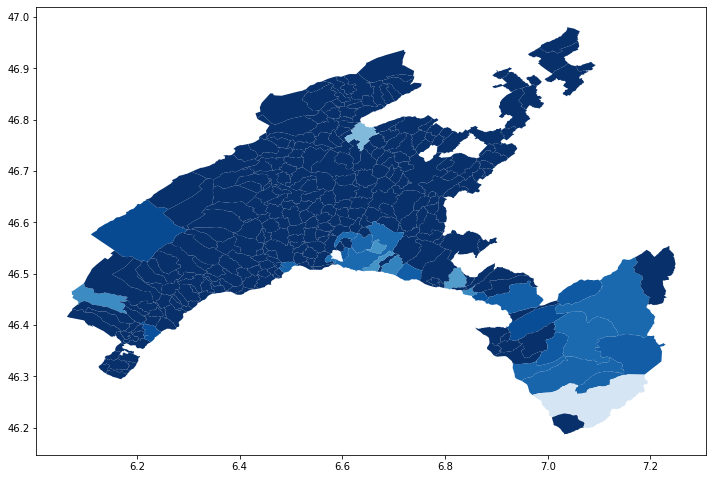

In [0]:
airbnb_merged.plot(column="demand_change_19_20", cmap="Blues_r", figsize=(12,10))

In [0]:
# Export GeoJSON with Vaud Boundaries and AirBNB review counts and demnad change from 2019 to 2020
airbnb_merged.to_file("airbnb_vaud_reviews_2019_2020.geojson", driver="GeoJSON")

## Instagram Data

In [0]:
# Read in geotagged social media data
social = pd.read_csv('http://cultureincities.com/sport/data/social/social_vaud_january_2020.csv')
social.head()

,time,date,year,month,day,hour,minute,second,node.text,display_url,location.name,tags,location.name.1,latitude,longitude,id
0,2020-01-31 10:52:58,2020-01-31,2020,1,31,10,52,58,#lausanne is pure ✨ and my new home.,https://scontent-lhr8-1.cdninstagram.com/v/t51...,"Lausanne, Switzerland",['lausanne'],"Lausanne, Switzerland",46.519653,6.632273,2233449737175186469
1,2020-01-25 18:55:09,2020-01-25,2020,1,25,18,55,9,~ @lausanne2020 ~\nTrop contente d'avoir pu ou...,https://scontent-lhr8-1.cdninstagram.com/v/t51...,"Leysin, Switzerland","['yog2020', 'joj2020', 'lausanne2020']","Leysin, Switzerland",46.343563,7.012033,2229343776896126062
2,2020-01-11 18:12:12,2020-01-11,2020,1,11,18,12,12,#vortexlausanne #olympicvillage #lausanne2020 ...,https://scontent-lht6-1.cdninstagram.com/v/t51...,Lausanne 2020,"['lausanne2020', 'olympicvillage', 'vortexlaus...",Lausanne 2020,46.519653,6.632273,2219175295801182910
3,2020-01-11 18:11:55,2020-01-11,2020,1,11,18,11,55,#vortexlausanne #olympicvillage #lausanne2020 ...,https://scontent-lht6-1.cdninstagram.com/v/t51...,Lausanne 2020,"['lausanne2020', 'olympicvillage', 'vortexlaus...",Lausanne 2020,46.519653,6.632273,2219175153186581983
4,2020-01-11 18:11:39,2020-01-11,2020,1,11,18,11,39,#vortexlausanne #olympicvillage #lausanne2020 ...,https://scontent-lht6-1.cdninstagram.com/v/t51...,Lausanne 2020,"['lausanne2020', 'olympicvillage', 'vortexlaus...",Lausanne 2020,46.519653,6.632273,2219175024287026237


In [0]:
# Limit the geotagge social media data to Vaud
social = social[(social.longitude >= 5.4749) & (social.longitude <= 7.5)]
social = social[(social.latitude >= 45.7908) & (social.latitude <= 47.7821)]

In [0]:
social.shape

(5617, 16)

In [0]:
# Transform the pandas df file into a geopandas df (Geometry from point polygon!)
social_geo = gpd.GeoDataFrame(social, geometry=gpd.points_from_xy(social.longitude, social.latitude))

In [0]:
social_geo.crs = 'EPSG:4326'
gdf_vaud.crs = 'EPSG:4326'

### Spatial join

In [0]:
# Do a spatial join of the Vaud Boundary data and the Airbnb listings
sjoined_social = gpd.sjoin(gdf_vaud, social_geo, op="contains")
sjoined_social.head()

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,index_right,time,date,year,month,day,hour,minute,second,node.text,display_url,location.name,tags,location.name.1,latitude,longitude,id
10,39,1.203210e+07,19421.322828,22,Orbe,ORBE,2224,5757,271,4,"POLYGON ((6.53921 46.69750, 6.53579 46.69798, ...",2409,2020-01-18 13:10:00,2020-01-18,2020,1,18,13,10,0,Citius - Altius - Fortius #lausanne2020 #olymp...,https://scontent-lht6-1.cdninstagram.com/v/t51...,"Orbe, Switzerland","['lausanne2020', 'olimpiadi', 'love', 'family'...","Orbe, Switzerland",46.729330,6.532359,2224096629693570359
21,50,1.519190e+07,21399.557469,22,Gryon,GRYON,2221,5405,5,1,"POLYGON ((7.14664 46.30466, 7.14991 46.30377, ...",4396,2020-01-12 19:38:03,2020-01-12,2020,1,12,19,38,3,Tribunal d'arrondissement de Lausanne 🇨🇭🇨🇭🇨🇭 #...,https://scontent-lhr8-1.cdninstagram.com/v/t51...,"Gryon, Switzerland","['gryon', 'jeuxolympics', 'lausanne2020', 'vil...","Gryon, Switzerland",46.277833,7.067589,2219943284944328149
21,50,1.519190e+07,21399.557469,22,Gryon,GRYON,2221,5405,5,1,"POLYGON ((7.14664 46.30466, 7.14991 46.30377, ...",4129,2020-01-13 15:14:45,2020-01-13,2020,1,13,15,14,45,#lausanne2020 #SamsungYodliPark,https://scontent-lht6-1.cdninstagram.com/v/t51...,"Gryon, Switzerland","['gryon', 'vaud', 'swiss', 'Schweiz', 'switzer...","Gryon, Switzerland",46.277833,7.067589,2220535536521702249
21,50,1.519190e+07,21399.557469,22,Gryon,GRYON,2221,5405,5,1,"POLYGON ((7.14664 46.30466, 7.14991 46.30377, ...",2450,2020-01-18 11:30:19,2020-01-18,2020,1,18,11,30,19,"Caption this? 🤔🥌 For more action, fun and behi...",https://scontent-lht6-1.cdninstagram.com/v/t51...,Villars-Gryon-les Chaux,['lausanne2020'],Villars-Gryon-les Chaux,46.282298,7.094511,2224046453009840366
21,50,1.519190e+07,21399.557469,22,Gryon,GRYON,2221,5405,5,1,"POLYGON ((7.14664 46.30466, 7.14991 46.30377, ...",2648,2020-01-17 17:08:32,2020-01-17,2020,1,17,17,8,32,Day 8: Freestyle Ski and Snowboard + half pipe...,https://scontent-lht6-1.cdninstagram.com/v/t51...,Boulangerie D&G Charlet-Ançay,"['yodli', 'gryon', 'bread', 'lausanne2020', 'c...",Boulangerie D&G Charlet-Ançay,46.282781,7.070683,2223491908590947540


In [0]:
social_post_neighbourhood = sjoined_social.neighbourhood.value_counts().reset_index()
social_post_neighbourhood.columns = ['neighbourhood', 'count']

In [0]:
social_post_neighbourhood.head()

,neighbourhood,count
0,Lausanne,3202
1,Prilly,724
2,Ormont-Dessus,298
3,Leysin,277
4,Ollon,222


In [0]:
social_merged = gdf_vaud.merge(social_post_neighbourhood, on='neighbourhood', how='outer')

print(social_merged.shape)
social_merged.head()

(309, 12)


,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,count
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ...",NaN
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ...",NaN
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",NaN
3,32,2.904487e+06,8368.067727,22,Coinsins,COINSINS,2228,5710,231,8,"POLYGON ((6.25078 46.41559, 6.24994 46.41530, ...",NaN
4,33,1.018120e+07,18942.417911,22,Grandcour,GRANDCOUR,2222,5817,309,2,"POLYGON ((6.91080 46.88062, 6.91791 46.88414, ...",NaN


In [0]:
social_merged = social_merged.fillna(0)

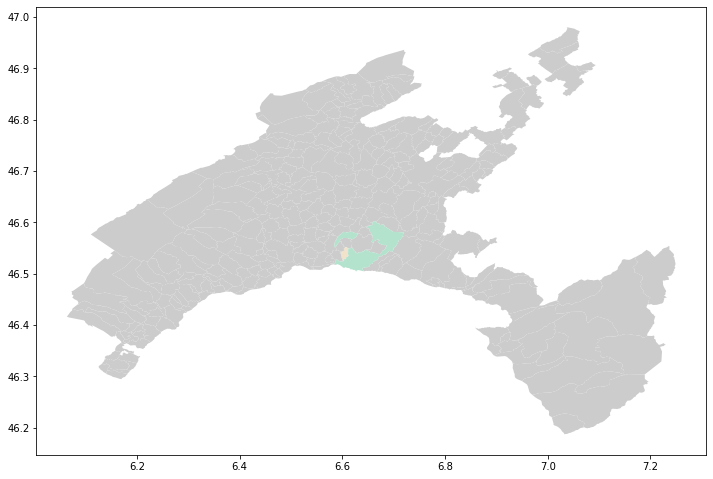

In [0]:
social_merged.plot(column="count", cmap="Pastel2_r", figsize=(12,10))

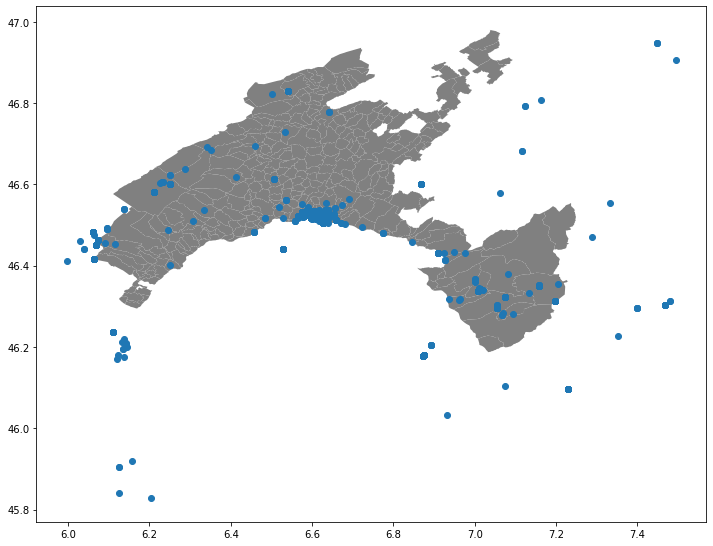

In [0]:
# Plot the geotagged social media posts on top of the Vaud Boundary data
fig, ax = plt.subplots(figsize=(12,10))
gdf_vaud.plot(color="Gray", ax= ax);
social_geo.plot(ax=ax);